#Data_Set : Hotel/Resort Customer Reviews

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.impute import SimpleImputer


In [199]:
# 
nltk.download('stopwords')
print(stopwords.words('english')[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saikrishna_gajula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [200]:
# Load the data
df = pd.read_csv('Data Analyst - Test.csv')

In [201]:
def parse_dates(date_str):
    if '/' in date_str:  # Check for 'YYYY/MM/DD' format
        return pd.to_datetime(date_str, format='%Y/%m/%d', errors='coerce')
    else:  # Handle 'Month Year' format
        return pd.to_datetime(date_str, format='%b %Y', errors='coerce')

# Apply the custom date parser
df['date'] = df['date'].apply(parse_dates)

# Check for any NaT values after parsing dates
if df['date'].isna().any():
    print("Warning: Some dates could not be parsed and are set to NaT.")

In [202]:
# Location Distribution Analysis
def analyze_location_distribution(df, top_n=10):
    """Analyzes and visualizes the distribution of reviews by location."""
    location_counts = df['Location'].value_counts().head(top_n)
    
    # Create a horizontal bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.barh(location_counts.index, location_counts.values, color='skyblue')
    
    # Add data labels
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                 f'{bar.get_width()}', va='center', ha='left', fontsize=10)

    # Enhance the plot's aesthetics
    plt.title('Top Review Distribution by Location', fontsize=16)
    plt.xlabel('Number of Reviews', fontsize=14)
    plt.ylabel('Location', fontsize=14)
    plt.xlim(0, location_counts.max() + 5) 
    plt.tight_layout()
    plt.savefig('location_distribution.png')
    plt.show() 
    return location_counts


In [203]:
# Temporal Analysis
def temporal_analysis(df, frequency='M'):
    """Analyzes and visualizes the distribution of reviews over time, aggregated by month or week."""
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Group by the specified frequency (monthly or weekly)
    date_counts = df.resample(frequency, on='date').size()

    # Calculate a moving average (for smoothing)
    moving_average = date_counts.rolling(window=3).mean()  # 3-period moving average

    # Create a line plot with moving average
    plt.figure(figsize=(12, 6))
    plt.plot(date_counts.index, date_counts, label='Daily Reviews', color='cyan', alpha=0.5)
    plt.plot(moving_average.index, moving_average, label='Moving Average (3 periods)', color='blue', linewidth=2)

    # Enhance the plot's aesthetics
    plt.title('Reviews Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Reviews', fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('temporal_analysis.png')
    plt.show()  
    return date_counts


In [204]:
# Sentiment Analysis
def perform_sentiment_analysis(df):
    """Performs sentiment analysis by counting positive and negative keywords."""
    positive_keywords = ['great', 'loved', 'excellent', 'nice', 'clean', 'comfortable', 'friendly']
    negative_keywords = ['old', 'musty', 'small', 'needs work', 'thin', 'poor', 'unresponsive']
    
    def count_sentiment_keywords(review):
        # Check if review is a string before processing
        if isinstance(review, str):
            review = review.lower()
            pos_count = sum(keyword in review for keyword in positive_keywords)
            neg_count = sum(keyword in review for keyword in negative_keywords)
            return pos_count, neg_count
        else:
            return 0, 0  # Handle non-string cases
    
    # Fill NaN values with empty string and apply the sentiment counting function
    df[['positive_count', 'negative_count']] = df['Review'].fillna('').apply(
        lambda x: pd.Series(count_sentiment_keywords(x))
    )

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))

    # Use a hexbin plot for better density visualization
    plt.hexbin(df['positive_count'], df['negative_count'], gridsize=30, cmap='Blues', mincnt=1)
    
    # Fit a linear regression model to plot a trend line
    X = df['positive_count'].values.reshape(-1, 1)
    y = df['negative_count'].values
    reg = LinearRegression().fit(X, y)
    plt.plot(df['positive_count'], reg.predict(X), color='red', linewidth=2, label='Trend Line')

    plt.title('Sentiment Analysis: Positive vs Negative Keywords', fontsize=16)
    plt.xlabel('Positive Keyword Count', fontsize=14)
    plt.ylabel('Negative Keyword Count', fontsize=14)
    plt.colorbar(label='Density')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('sentiment_analysis_hexbin.png')
    plt.show() 
    return df[['positive_count', 'negative_count']]


In [205]:
# Review Length Analysis
def analyze_review_length(df):
    """Analyzes and visualizes the length of reviews."""
    df['review_length'] = df['Review'].str.len()
    plt.figure(figsize=(10, 6))
    df['review_length'].plot(kind='hist', bins=20)
    plt.title('Distribution of Review Lengths')
    plt.xlabel('Review Length (characters)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('review_length_distribution.png')
    return df['review_length']

In [206]:
# Topic Modeling
def topic_modeling(df, n_topics=5):
    """Performs topic modeling using LDA."""
    reviews = df['Review'].dropna().values
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    review_matrix = vectorizer.fit_transform(reviews)
    
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(review_matrix)
    
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([words[i] for i in topic.argsort()[:-11:-1]]))
    
    return lda


In [207]:
# Sentiment Trends Over Time
def sentiment_trends_over_time(df):
    """Visualizes sentiment trends over time."""
    df['date'] = pd.to_datetime(df['date'])
    sentiment_trends = df.groupby(df['date'].dt.to_period('M')).agg({
        'positive_count': 'sum',
        'negative_count': 'sum'
    })
    
    sentiment_trends.plot(kind='line', figsize=(14, 7), marker='o')
    plt.title('Sentiment Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count of Sentiment Keywords')
    plt.tight_layout()
    plt.show()
    
    return sentiment_trends


In [208]:
# Keyword Frequency Analysis
def analyze_keyword_frequency(df):
    """Analyzes and visualizes the frequency of keywords in reviews."""
    all_reviews = ' '.join(df['Review'].fillna(''))
    stop_words = set(stopwords.words('english'))
    words = re.findall(r'\w+', all_reviews.lower())
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    word_freq = Counter(filtered_words)
    top_words = word_freq.most_common(15)
    
    plt.figure(figsize=(12, 6))
    plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
    plt.title('Top 15 Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('keyword_frequency.png')
    return dict(top_words)

In [209]:
# Polarity and Subjectivity Analysis
def analyze_polarity_subjectivity(df):
    """Analyzes the polarity and subjectivity of reviews."""
    
    # Ensure that all reviews are strings
    df['Review'] = df['Review'].fillna('').astype(str)
    
    df['polarity'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df['polarity'], kde=True, bins=20, color='blue')
    plt.title('Polarity Distribution of Reviews')
    plt.xlabel('Polarity')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('polarity_distribution.png')
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df['subjectivity'], kde=True, bins=20, color='green')
    plt.title('Subjectivity Distribution of Reviews')
    plt.xlabel('Subjectivity')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('subjectivity_distribution.png')
    
    return df[['polarity', 'subjectivity']]

In [210]:
# Word Cloud Generation
def generate_word_cloud(df, sentiment='positive'):
    """Generates a word cloud for positive or negative reviews."""
    if sentiment == 'positive':
        reviews = ' '.join(df[df['positive_count'] > df['negative_count']]['Review'].fillna(''))
    else:
        reviews = ' '.join(df[df['negative_count'] > df['positive_count']]['Review'].fillna(''))
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment.capitalize()} Review Word Cloud')
    plt.tight_layout()
    plt.savefig(f'{sentiment}_word_cloud.png')
    plt.show()

In [211]:
# Seasonal Review Traction
def add_season_column(df):
    """Adds a season column based on the date of the review."""
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Autumn'
    
    df['Season'] = df['month'].apply(get_season)
    return df

def seasonal_review_analysis(df):
    """Analyzes the number of reviews and positive/negative counts by season."""
    seasonal_sentiment = df.groupby('Season').agg({
        'positive_count': 'sum',
        'negative_count': 'sum',
        'Review': 'count'
    }).sort_index()
    
    seasonal_sentiment.plot(kind='bar', figsize=(12, 6), color=['green', 'red', 'blue'])
    plt.title('Seasonal Analysis of Reviews')
    plt.xlabel('Season')
    plt.ylabel('Counts')
    plt.tight_layout()
    plt.show()
    
    return seasonal_sentiment


In [212]:
# Area Wise Sentiment Analysis
def area_wise_sentiment_analysis(df):
    """Analyzes and plots sentiment distribution by location."""
    location_sentiment = df.groupby('Location').agg({
        'positive_count': 'sum',
        'negative_count': 'sum'
    }).sort_values(by='positive_count', ascending=False)
    
    location_sentiment.plot(kind='bar', stacked=True, figsize=(15, 8), color=['green', 'red'])
    plt.title('Area-wise Positive and Negative Reviews')
    plt.xlabel('Location')
    plt.ylabel('Count of Keywords')
    plt.tight_layout()
    plt.show()
    
    return location_sentiment


In [213]:
#Review Authenticity Check
def review_authenticity_check(df):
    """Checks review authenticity by looking at review length and unique word count."""
    df['review_length'] = df['Review'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df['unique_word_count'] = df['Review'].apply(lambda x: len(set(x.split())) if isinstance(x, str) else 0)
    
    # Visualize review length distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(df['review_length'], bins=50, kde=True, color='blue')
    plt.title('Review Length Distribution')
    plt.xlabel('Review Length (in words)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    return df[['review_length', 'unique_word_count']]


In [214]:
# Deeper Emotion Analysis
def deeper_emotion_analysis(df):
    """Performs sentiment analysis using TextBlob for polarity and subjectivity."""
    df['polarity'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)
    df['subjectivity'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity if isinstance(x, str) else 0)
    
    # Plotting polarity and subjectivity distribution
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='polarity', y='subjectivity', data=df, alpha=0.6)
    plt.title('Emotion Analysis: Polarity vs Subjectivity')
    plt.xlabel('Polarity')
    plt.ylabel('Subjectivity')
    plt.tight_layout()
    plt.show()
    
    return df[['polarity', 'subjectivity']]


In [215]:
# Outlier Detection
def outlier_detection(df, column='review_length'):
    """Detects outliers using the IQR method for a given column."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers in '{column}':", len(outliers))
    
    return outliers


In [216]:
# Sentiment by Category
def sentiment_by_category(df, category_col='Category'):
    """Analyzes sentiment distribution by product or service category."""
    category_sentiment = df.groupby(category_col).agg({
        'positive_count': 'sum',
        'negative_count': 'sum'
    }).sort_values(by='positive_count', ascending=False)
    
    category_sentiment.plot(kind='bar', stacked=True, figsize=(15, 8), color=['green', 'red'])
    plt.title('Sentiment by Product/Service Category')
    plt.xlabel('Category')
    plt.ylabel('Count of Keywords')
    plt.tight_layout()
    plt.show()
    
    return category_sentiment


In [217]:
# Geographical Distribution Analysis
def geographical_distribution_analysis(df, geo_col='Location', map_file='path/to/shapefile.shp'):
    """Plots a geographical distribution of reviews on a map using GeoPandas."""
    gdf = gpd.read_file(map_file)
    location_counts = df[geo_col].value_counts()
    
    # Merge with geospatial data
    gdf['count'] = gdf[geo_col].map(location_counts)
    gdf['count'].fillna(0, inplace=True)
    
    gdf.plot(column='count', cmap='OrRd', legend=True, figsize=(15, 10))
    plt.title('Geographical Distribution of Reviews')
    plt.tight_layout()
    plt.show()
    
    return gdf


In [218]:
# Customer Segmentation
def customer_segmentation(df):
    """Segments customers based on specified features for clustering."""
    # Define features to use in segmentation
    features = ['review_length', 'positive_count', 'negative_count'] 
    
    df = df.dropna(subset=features).copy()
    
    imputer = SimpleImputer(strategy='mean')
    df[features] = imputer.fit_transform(df[features])

    scaler = StandardScaler()
    X = scaler.fit_transform(df[features])

    # KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['segment'] = kmeans.fit_predict(X)

    # Visualize the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=features[0], y=features[1], hue='segment', data=df, palette='viridis')
    plt.title('Customer Segmentation')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend(title='Segment')
    plt.tight_layout()
    plt.savefig('customer_segmentation.png')
    
    return df[['segment'] + features]



In [219]:
# Main Analysis Function
def comprehensive_hotel_review_analysis(df):
    """Performs a comprehensive analysis of hotel reviews."""
    # Ensure required columns are present
    required_columns = ['Location', 'date', 'Review']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    results = {}

    # Location distribution analysis
    print("Analyzing location distribution...")
    results['Location Distribution'] = analyze_location_distribution(df)

    # Temporal distribution analysis
    print("Analyzing temporal distribution of reviews...")
    results['Temporal Analysis'] = temporal_analysis(df)

    # Sentiment analysis
    print("Performing sentiment analysis...")
    results['Sentiment Analysis'] = perform_sentiment_analysis(df)

    # Review length analysis
    print("Analyzing review length...")
    results['Review Length'] = analyze_review_length(df)

    # Keyword frequency analysis
    print("Analyzing keyword frequency...")
    results['Keyword Frequency'] = analyze_keyword_frequency(df)

    # Polarity and subjectivity analysis
    print("Analyzing polarity and subjectivity...")
    results['Polarity and Subjectivity'] = analyze_polarity_subjectivity(df)

    # Generate word clouds for positive and negative sentiment
    print("Generating word clouds for visual insights...")
    generate_word_cloud(df, 'positive')
    generate_word_cloud(df, 'negative')

    # Additional analyses
    print("Performing outlier detection...")
    results['Outlier Detection'] = outlier_detection(df, 'review_length')

    print("Performing deeper emotion analysis...")
    results['Deeper Emotion Analysis'] = deeper_emotion_analysis(df)

    print("Performing customer segmentation...")
    results['Customer Segmentation'] = customer_segmentation(df)

    print("Performing topic modeling...")
    results['Topic Modeling'] = topic_modeling(df)

    print("Analyzing sentiment trends over time...")
    results['Sentiment Trends Over Time'] = sentiment_trends_over_time(df)

    return results


Analyzing location distribution...


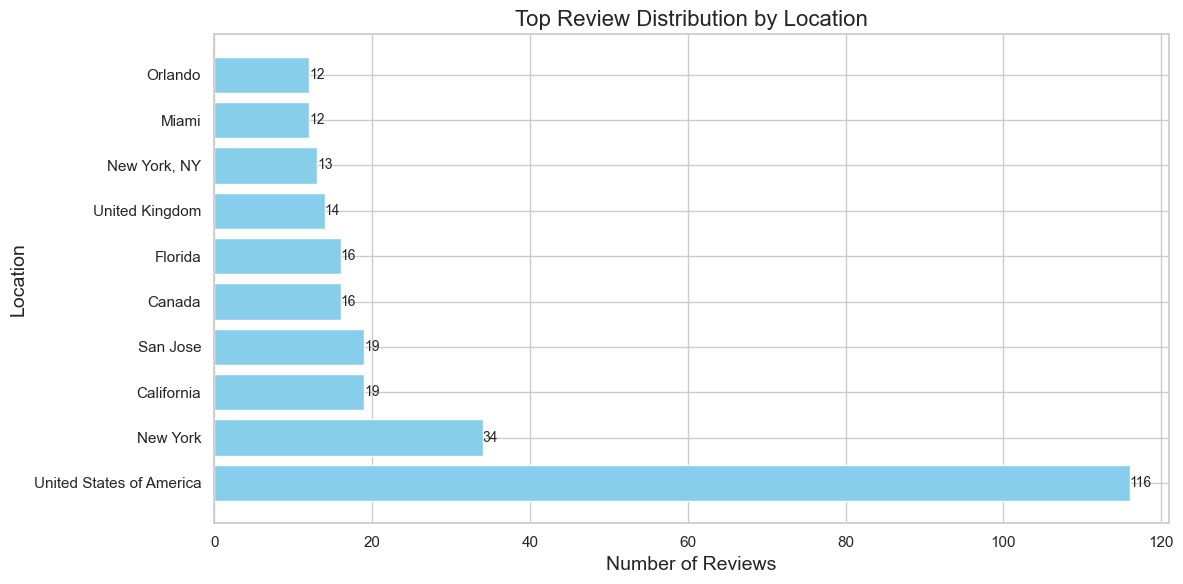

Analyzing temporal distribution of reviews...


/var/folders/52/dr9tscs95_37928gzg06xct00000gq/T/ipykernel_66159/459516671.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_counts = df.resample(frequency, on='date').size()


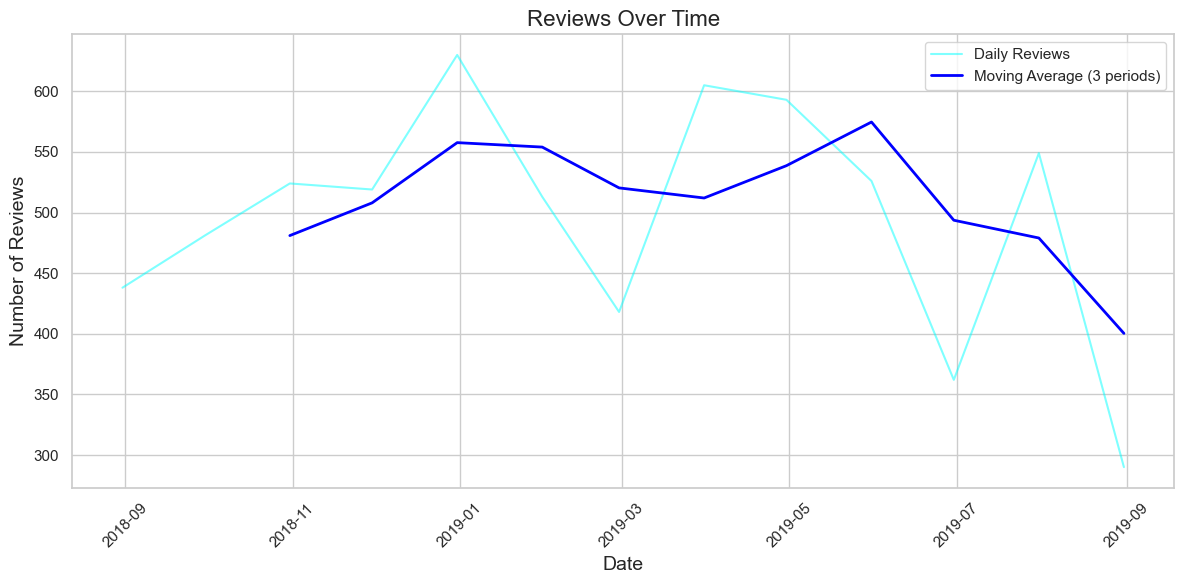

Performing sentiment analysis...


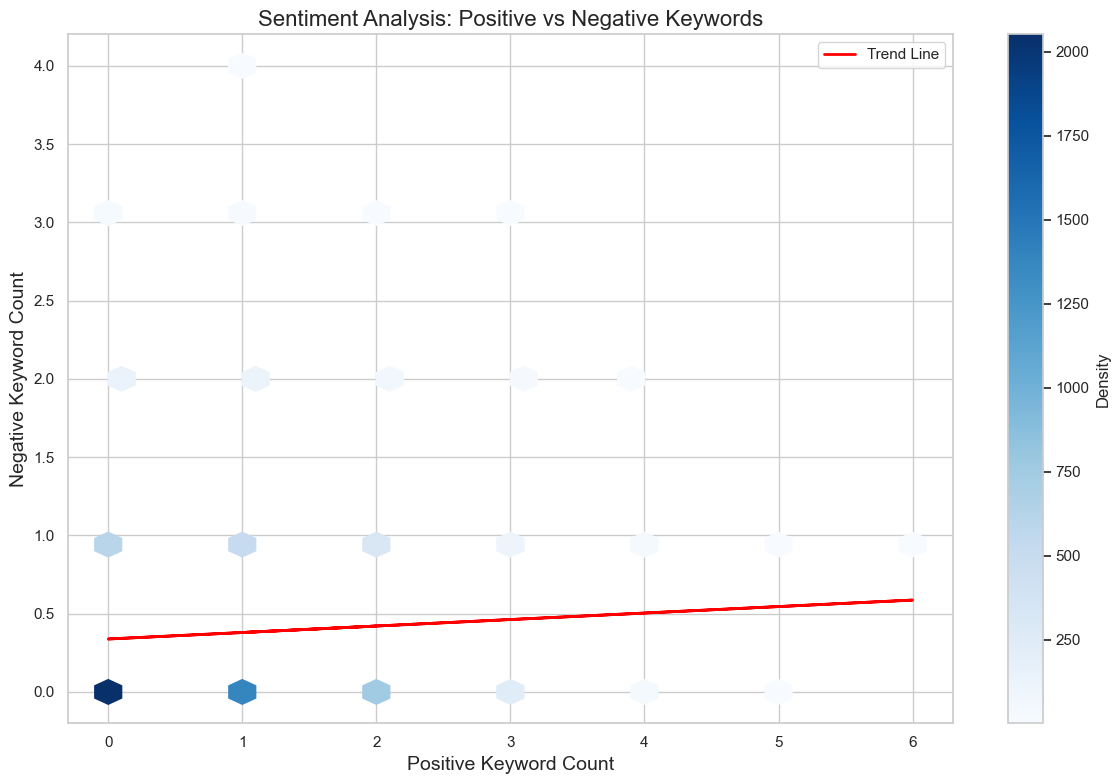

Analyzing review length...
Analyzing keyword frequency...
Analyzing polarity and subjectivity...
Generating word clouds for visual insights...


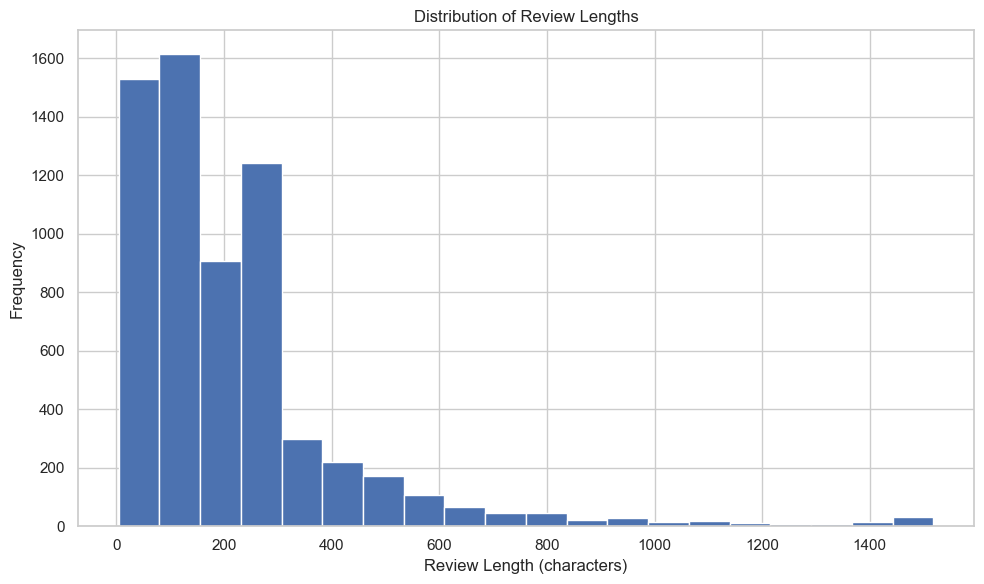

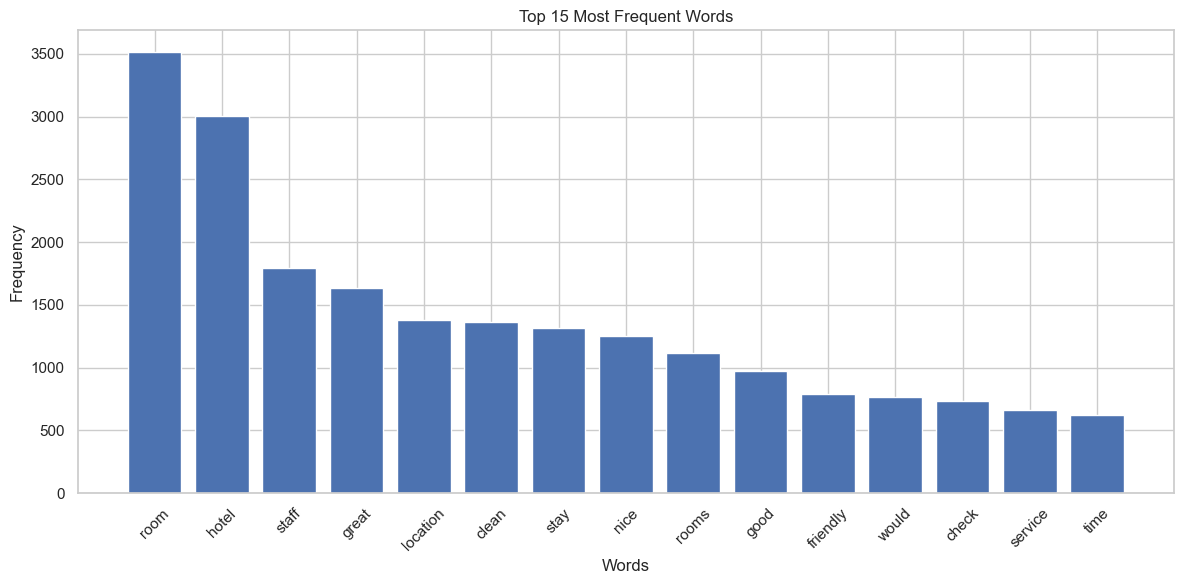

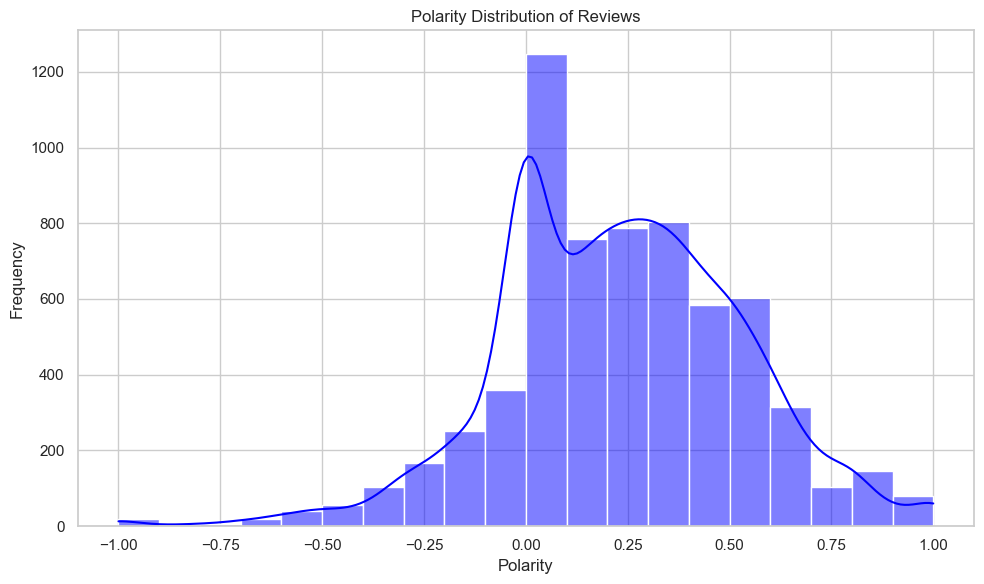

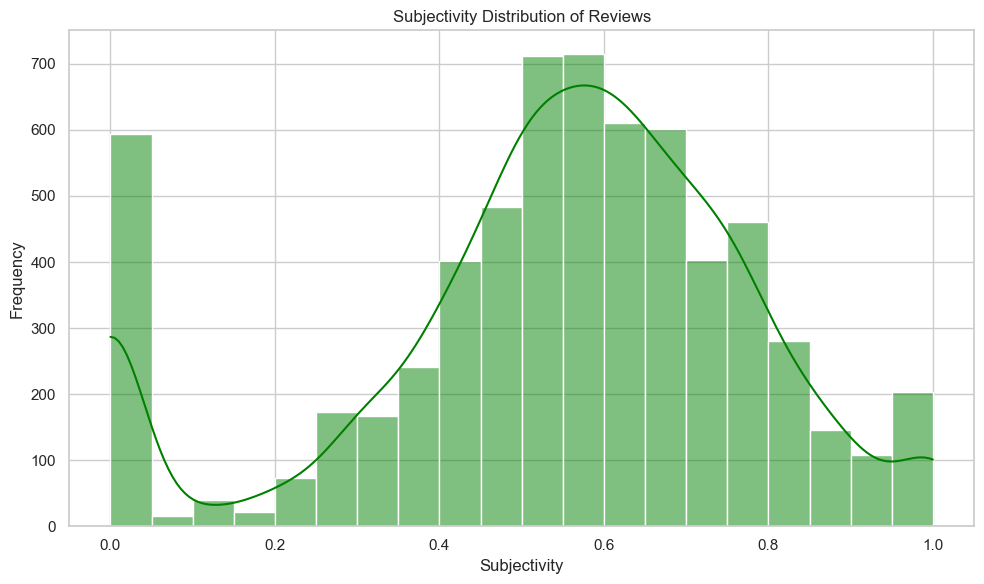

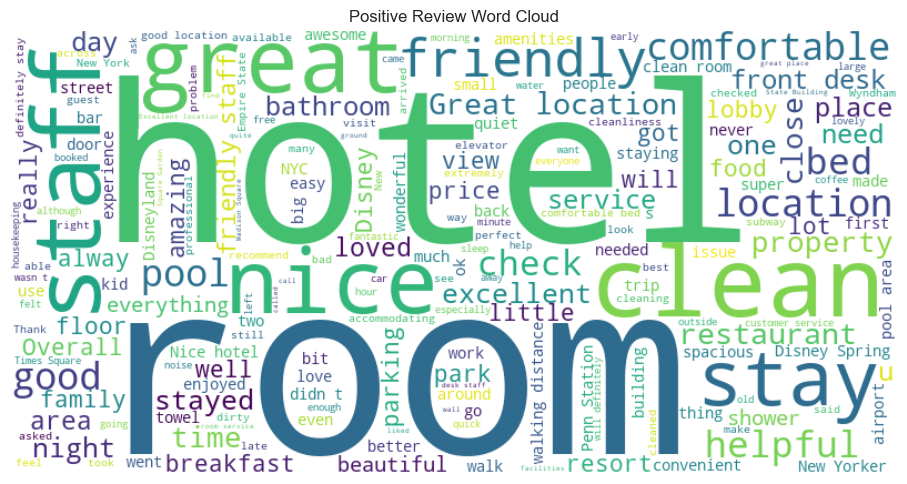

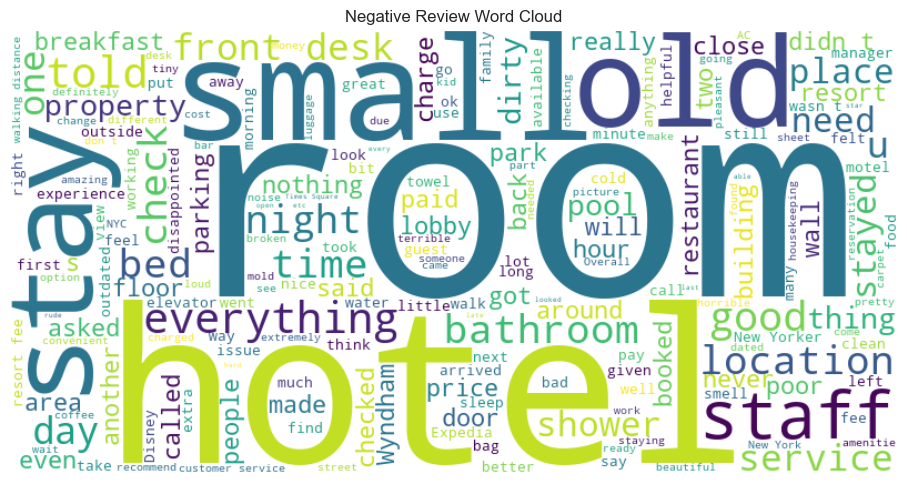

Performing outlier detection...
Number of outliers in 'review_length': 356
Performing deeper emotion analysis...


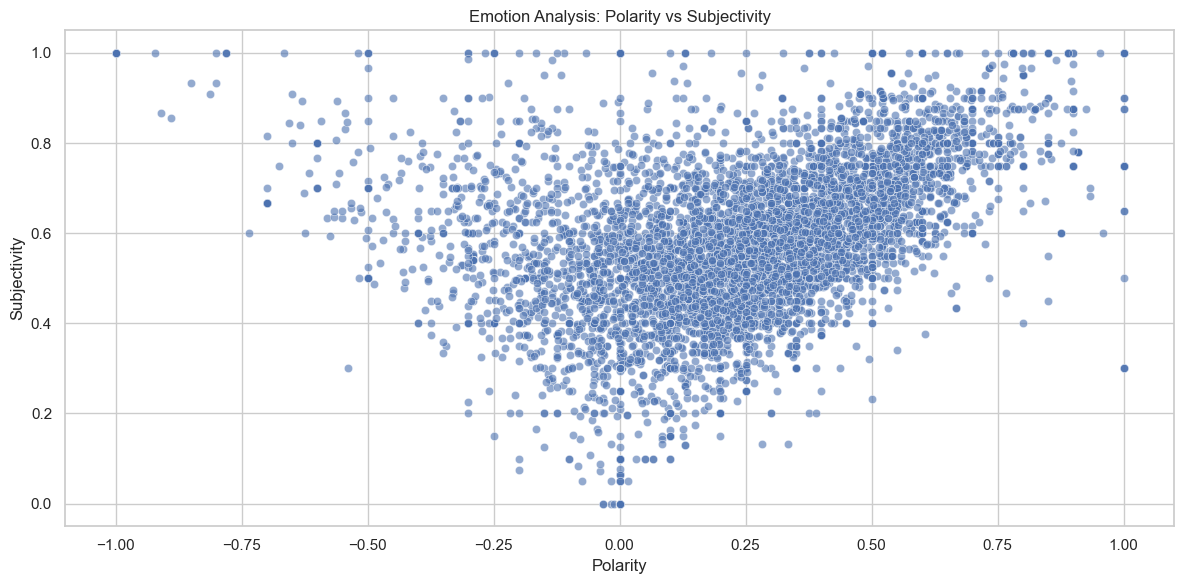

Performing customer segmentation...
Performing topic modeling...
Topic 1:
la hotel en el que muy die und es das
Topic 2:
hotel room great stay staff clean nice rooms location parking
Topic 3:
room check hotel desk night bed like didn did rooms
Topic 4:
staff nice clean friendly hotel helpful comfortable property room stay
Topic 5:
location hotel great staff new good square station close clean
Analyzing sentiment trends over time...


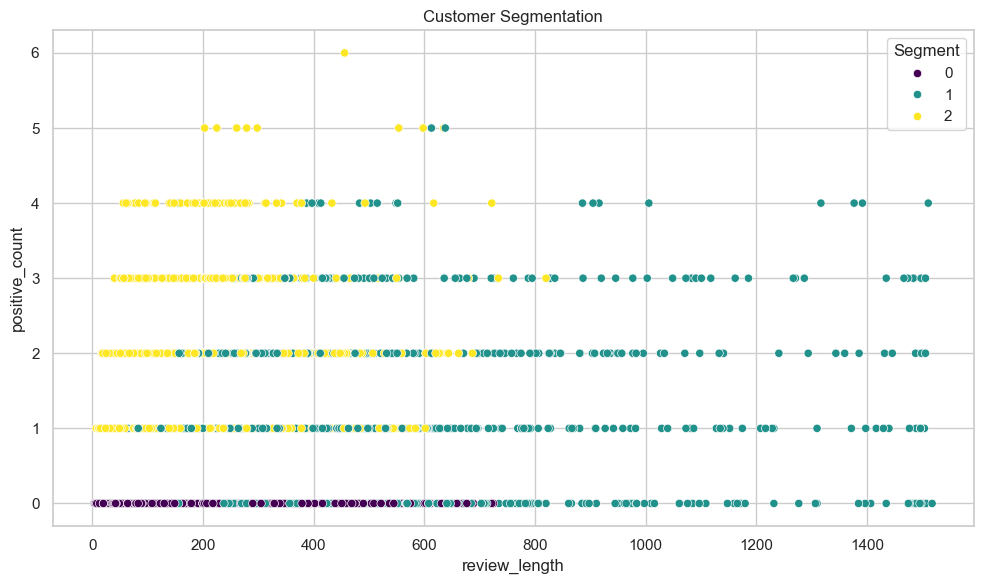

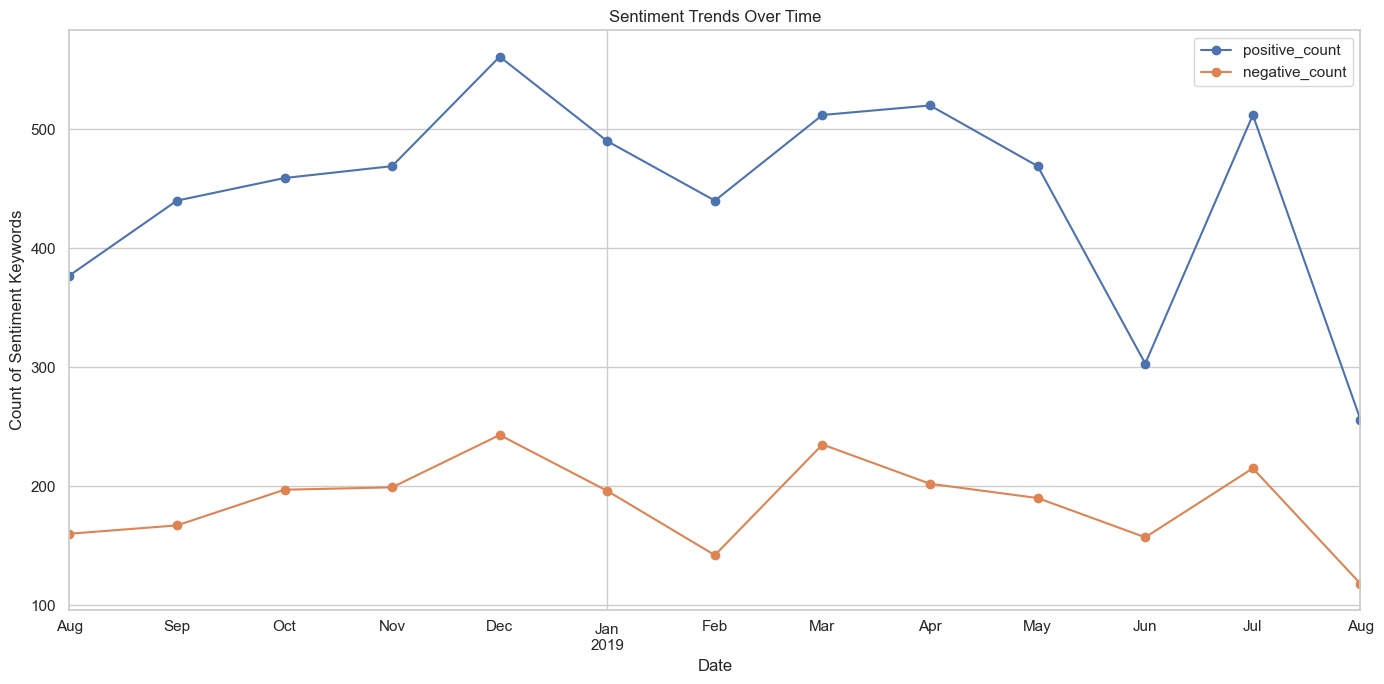

Analysis Complete. Check the generated visualizations!

Location Distribution:
Location
United States of America    116
New York                     34
California                   19
San Jose                     19
Canada                       16
Florida                      16
United Kingdom               14
New York, NY                 13
Miami                        12
Orlando                      12
Name: count, dtype: int64

Temporal Analysis:
date
2018-08-31    438
2018-09-30    481
2018-10-31    524
2018-11-30    519
2018-12-31    630
2019-01-31    513
2019-02-28    418
2019-03-31    605
2019-04-30    593
2019-05-31    526
2019-06-30    362
2019-07-31    549
2019-08-31    290
Freq: ME, dtype: int64

Sentiment Analysis:
      positive_count  negative_count
0                  2               0
1                  1               1
2                  1               0
3                  1               2
4                  2               0
...              ...             ...
6443

In [220]:
# Run the analysis
analysis_results = comprehensive_hotel_review_analysis(df)

# Print out key findings
print("Analysis Complete. Check the generated visualizations!")
for key, value in analysis_results.items():
    print(f"\n{key}:")
    print(value)